## FTP Connection

### Connection Parameters

In [234]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [235]:
# The topic of interest -Reading daily historical climate data
topic_dir = "/daily/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [236]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [237]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/kl/historical/
data/original/DWD//daily/kl/historical/

data/generated/DWD/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/


In [238]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [239]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [240]:
ret = ftp.cwd(".")
os.getcwd()

'C:\\Users\\Rajesh Rao\\OneDrive\\Documents\\Masters\\Winter\\GIS\\Final Assignment\\Python'

In [241]:
#ftp.quit()

### FTP Grab File Function

In [242]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [243]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [244]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [245]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_daily_kl_histo...,.pdf,74902,-
1,-1,DESCRIPTION_obsgermany_climate_daily_kl_histor...,.pdf,73419,-
2,-1,KL_Tageswerte_Beschreibung_Stationen.txt,.txt,267457,-
3,1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
4,3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-
5,11,tageswerte_KL_00011_19800901_20181231_hist.zip,.zip,83682,-
6,44,tageswerte_KL_00044_19690101_20181231_hist.zip,.zip,416393,-
7,52,tageswerte_KL_00052_19690101_20011231_hist.zip,.zip,261747,-
8,61,tageswerte_KL_00061_19750701_19780831_hist.zip,.zip,32904,-
9,70,tageswerte_KL_00070_19730601_19860930_hist.zip,.zip,100354,-


### Dataframe with TS Zip Files

In [246]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-
11,tageswerte_KL_00011_19800901_20181231_hist.zip,.zip,83682,-
44,tageswerte_KL_00044_19690101_20181231_hist.zip,.zip,416393,-
52,tageswerte_KL_00052_19690101_20011231_hist.zip,.zip,261747,-
61,tageswerte_KL_00061_19750701_19780831_hist.zip,.zip,32904,-
70,tageswerte_KL_00070_19730601_19860930_hist.zip,.zip,100354,-
71,tageswerte_KL_00071_19861101_20181231_hist.zip,.zip,200328,-
72,tageswerte_KL_00072_19780901_19950531_hist.zip,.zip,155186,-


### Download the Station Description File

In [247]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)


KL_Tageswerte_Beschreibung_Stationen.txt


In [248]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt


In [249]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [250]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1937-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
11,1980-09-01,2020-03-01,680,47.9737,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
44,1969-01-01,2020-03-01,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein


### Select Stations Located in NRW from Station Description Dataframe

In [251]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,    98,   186,   326,   386,   390,   553,   554,   555,
              598,
            ...
            13696, 13700, 13713, 13901, 13952, 15000, 15120, 15190, 15200,
            15963],
           dtype='int64', name='station_id', length=112)

### Exract Only NRW stations around Xanten area

In [252]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Nordrhein-Westfalen"  

# Create variable with TRUE if station name is Xanten
xanten= df_stations['name'] == "Xanten (Wasserwerk)"

dfXanten = df_stations[xanten]

# all the latitudes with in range XantenLatitude ± 0.5
isLatCovered = (df_stations['latitude'] < dfXanten.iloc[0]['latitude'] + 0.5)&(df_stations['latitude'] > dfXanten.iloc[0]['latitude'] - 0.5)

# all the latitudes with in range XantenLongitude ± 0.5 (± 0.5 because there were no dataset within the required date range)
isLongCovered = (df_stations['longitude'] < dfXanten.iloc[0]['longitude'] + 0.5)&(df_stations['longitude'] > dfXanten.iloc[0]['longitude'] - 0.5)

# Considering starting date range before 2015
dateFilter=(df_stations['date_from'] <= '2015')

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to']>= '2018' 


# select on all the conditions above
dfNRW = df_stations[isNRW  & dateFilter & isOperational & isLatCovered & isLongCovered]
#print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
617,2004-06-01,2020-03-01,47,51.8730,6.8863,Borken in Westfalen,Nordrhein-Westfalen
1078,1952-01-01,2020-03-01,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1590,1963-10-01,2020-03-01,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2629,1947-11-11,2020-03-01,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen
5064,2004-12-01,2020-03-01,37,51.2897,6.4437,Tönisvorst,Nordrhein-Westfalen
13670,2007-05-31,2020-03-01,24,51.5088,6.7018,Duisburg-Baerl,Nordrhein-Westfalen


In [253]:
#Export all the selected station data into csv
export_csv = dfNRW.to_csv (r'Temperature_Stations_Selected.csv', index = 'station_id', header=True)

In [254]:
df_zips.head()

,name,ext,size,type
station_id,,,,
1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-
11,tageswerte_KL_00011_19800901_20181231_hist.zip,.zip,83682,-
44,tageswerte_KL_00044_19690101_20181231_hist.zip,.zip,416393,-
52,tageswerte_KL_00052_19690101_20011231_hist.zip,.zip,261747,-


In [255]:
list(dfNRW.index)

[617, 1078, 1590, 2629, 5064, 13670]

In [256]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_KL_00617_20040601_20181231_hist.zip
tageswerte_KL_01078_19520101_20181231_hist.zip
tageswerte_KL_01590_19631001_20181231_hist.zip
tageswerte_KL_02629_19471111_20181231_hist.zip
tageswerte_KL_05064_20041201_20181231_hist.zip
tageswerte_KL_13670_20070531_20181231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [257]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [258]:
from zipfile import ZipFile

In [259]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                #print(dftmp)
                s = dftmp["tmk"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [260]:
df_merged_ts = temp_ts_merge()


Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_00617_20040601_20181231_hist.zip
Extract product file: produkt_klima_tag_20040601_20181231_00617.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_01078_19520101_20181231_hist.zip
Extract product file: produkt_klima_tag_19520101_20181231_01078.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_01590_19631001_20181231_hist.zip
Extract product file: produkt_klima_tag_19631001_20181231_01590.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_02629_19471111_20181231_hist.zip
Extract product file: produkt_klima_tag_19471111_20181231_02629.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_05064_20041201_20181231_hist.zip
Extract product file: produkt_klima_tag_20041201_20181231_05064.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_13670_20070531_20181231_hist.zip
Extract product file: produkt_klima_tag_20070531_20181231_136

In [261]:
df_merged_ts.head()

,617,1078,1590,2629,5064,13670
time,,,,,,
1947-11-11,NaN,NaN,NaN,10.6,NaN,NaN
1947-11-12,NaN,NaN,NaN,12.6,NaN,NaN
1947-11-13,NaN,NaN,NaN,8.1,NaN,NaN
1947-11-14,NaN,NaN,NaN,6.7,NaN,NaN
1947-11-15,NaN,NaN,NaN,4.8,NaN,NaN


### Selecting temperature data from stations selected, for the time range
### (a) 2015-05-09 to 2016-05-08 (b) 2016-05-27 to 2017-05-26 (c) 2017-07-01 to 2018-06-30

In [262]:
df_selectedDateRange=pd.DataFrame()

try:
    df_merged_ts.reset_index(level = 0, inplace = True)
except:
    df_merged_ts.reset_index(drop = True)    

# (a) 2016-05-08 (c) 2017-05-26 (e) 2018-06-30
date_from = [pd.Timestamp(2015, 5, 9), pd.Timestamp(2016, 5, 27), pd.Timestamp(2017, 7, 1)]
date_to = [pd.Timestamp(2016, 5, 8), pd.Timestamp(2017, 5, 26), pd.Timestamp(2018, 6, 30)]

i = 0
for item in date_from:
    isWithinDaterange = (df_merged_ts['time'] <= date_to[i]) & (df_merged_ts['time'] >= date_from[i])
    data_frame=df_merged_ts[isWithinDaterange]
    df_selectedDateRange = df_selectedDateRange.append(data_frame)
    i += 1

# Selecting the closest stations for xanten and taking the average temperature of 3 stations 1590(Geldern), 2629(Kleve), 13670(Duisburg)
df_selectedDateRange = df_selectedDateRange.drop([617, 1078, 5064], axis=1) #Dropping the unwanted stations from dataframe
df_selectedDateRange['AvgTemp_3Stations'] = df_selectedDateRange.iloc[:,1:].mean(axis=1)

# export to csv file for correlation calculation
export_csv = df_selectedDateRange.to_csv (r'Temperature_Full_Data.csv', index = False, header=True)   
df_selectedDateRange = df_selectedDateRange.rename(columns={1590: 'Geldern', 2629: 'Kleve', 13670:'Duisburg'})
df_selectedDateRange.head() 

,time,Geldern,Kleve,Duisburg,AvgTemp_3Stations
24651,2015-05-09,15.1,13.9,15.3,14.766667
24652,2015-05-10,14.4,13.2,13.9,13.833333
24653,2015-05-11,19.2,18.2,19.3,18.900000
24654,2015-05-12,16.3,15.1,16.5,15.966667
24655,2015-05-13,13.8,12.6,13.7,13.366667


### Plotting line graph for temperature data selected

In [263]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

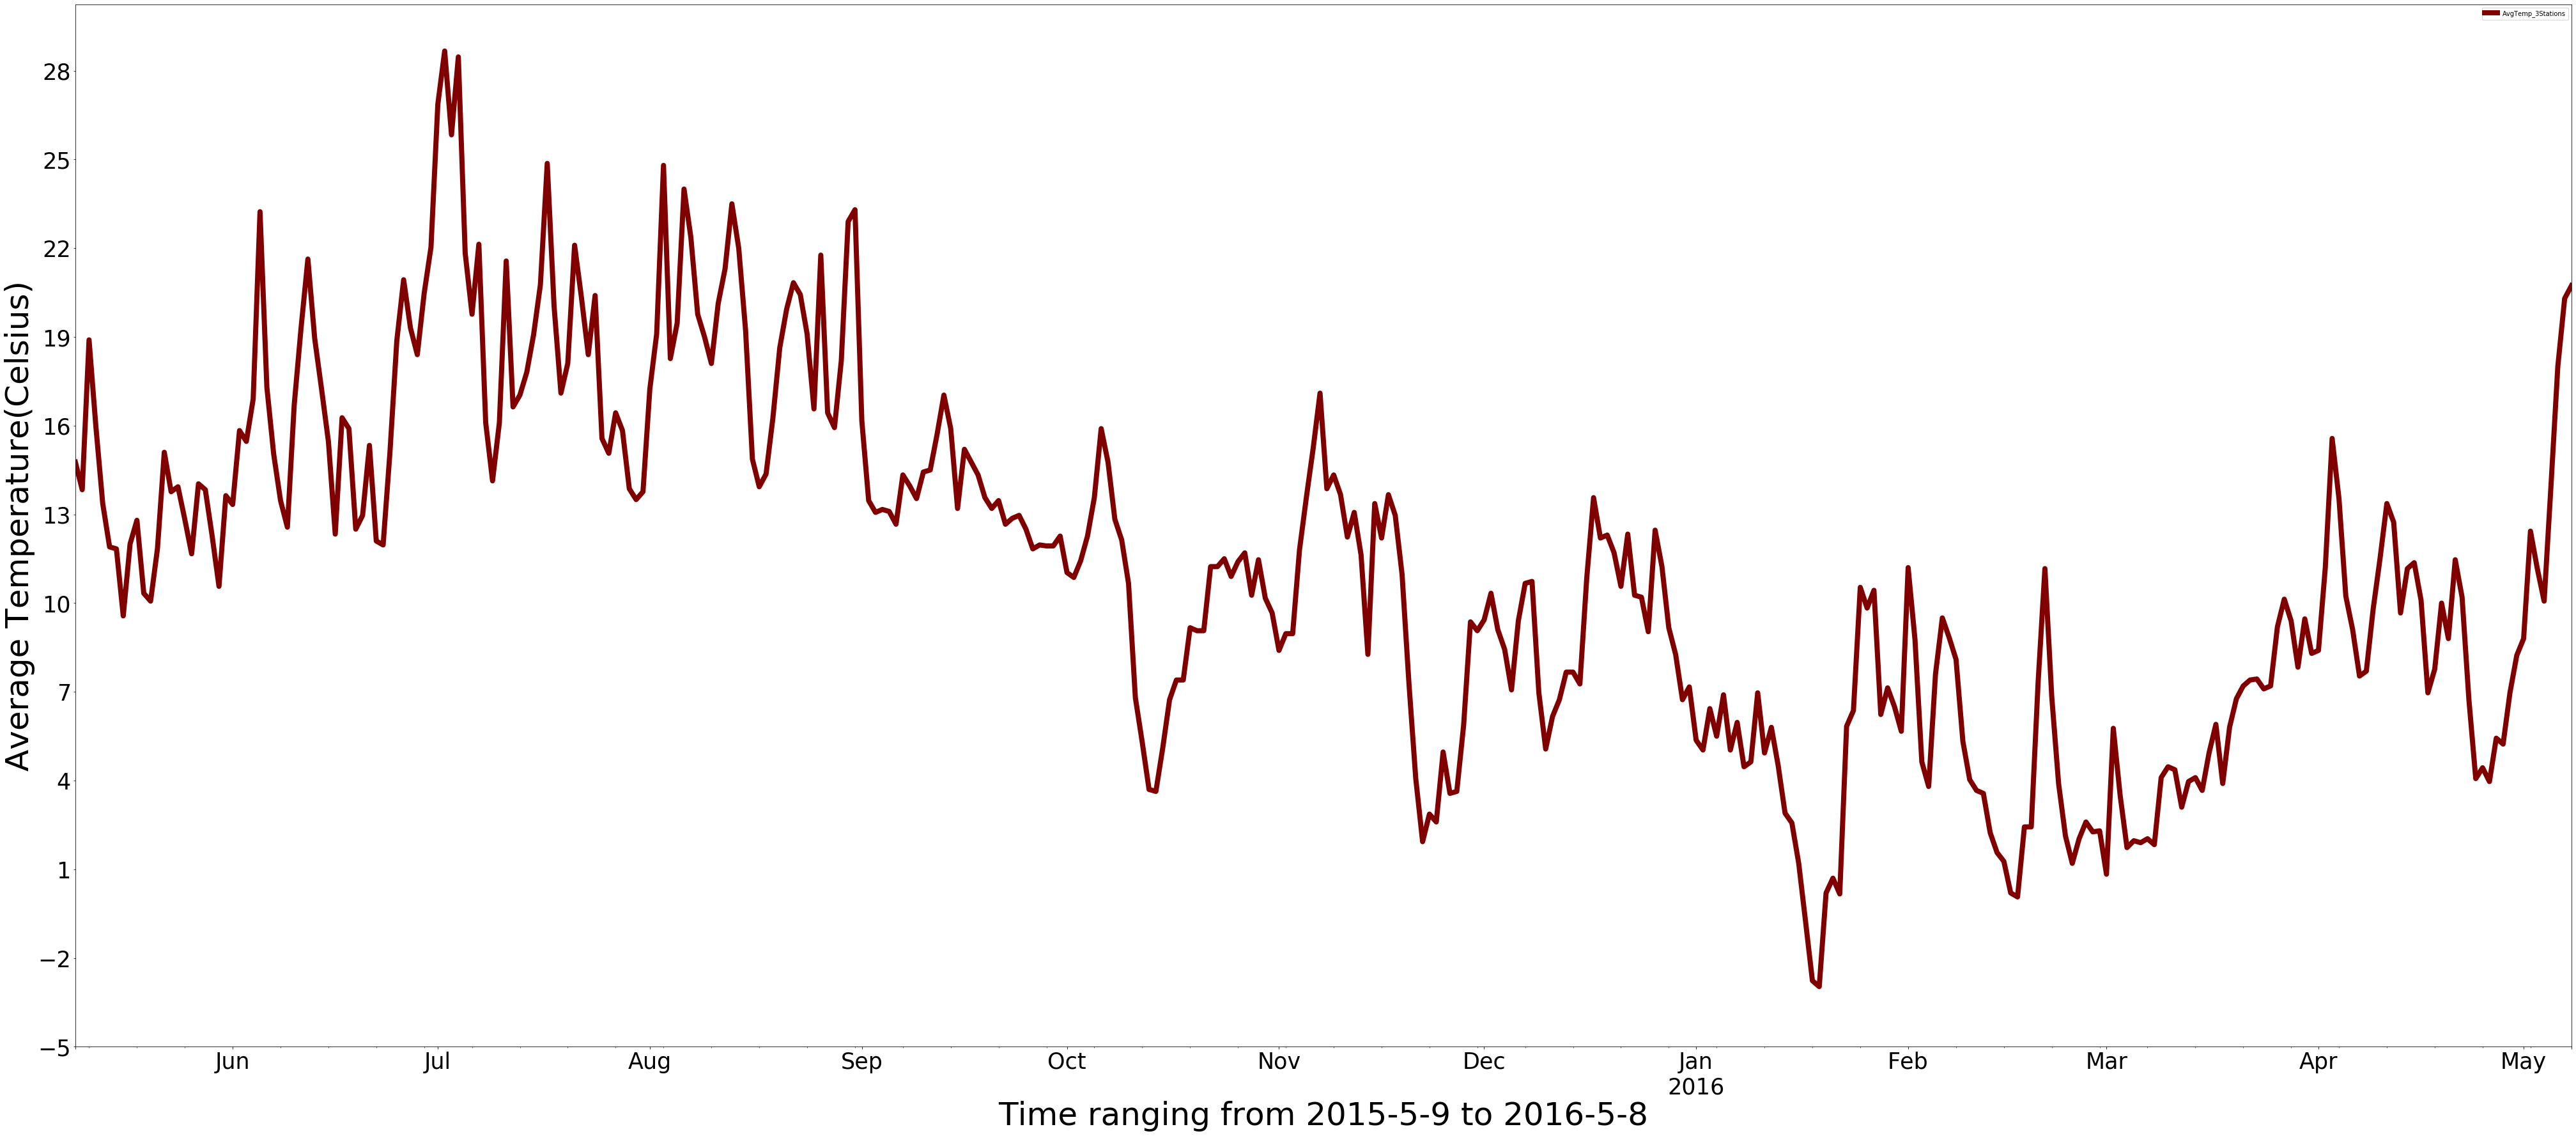

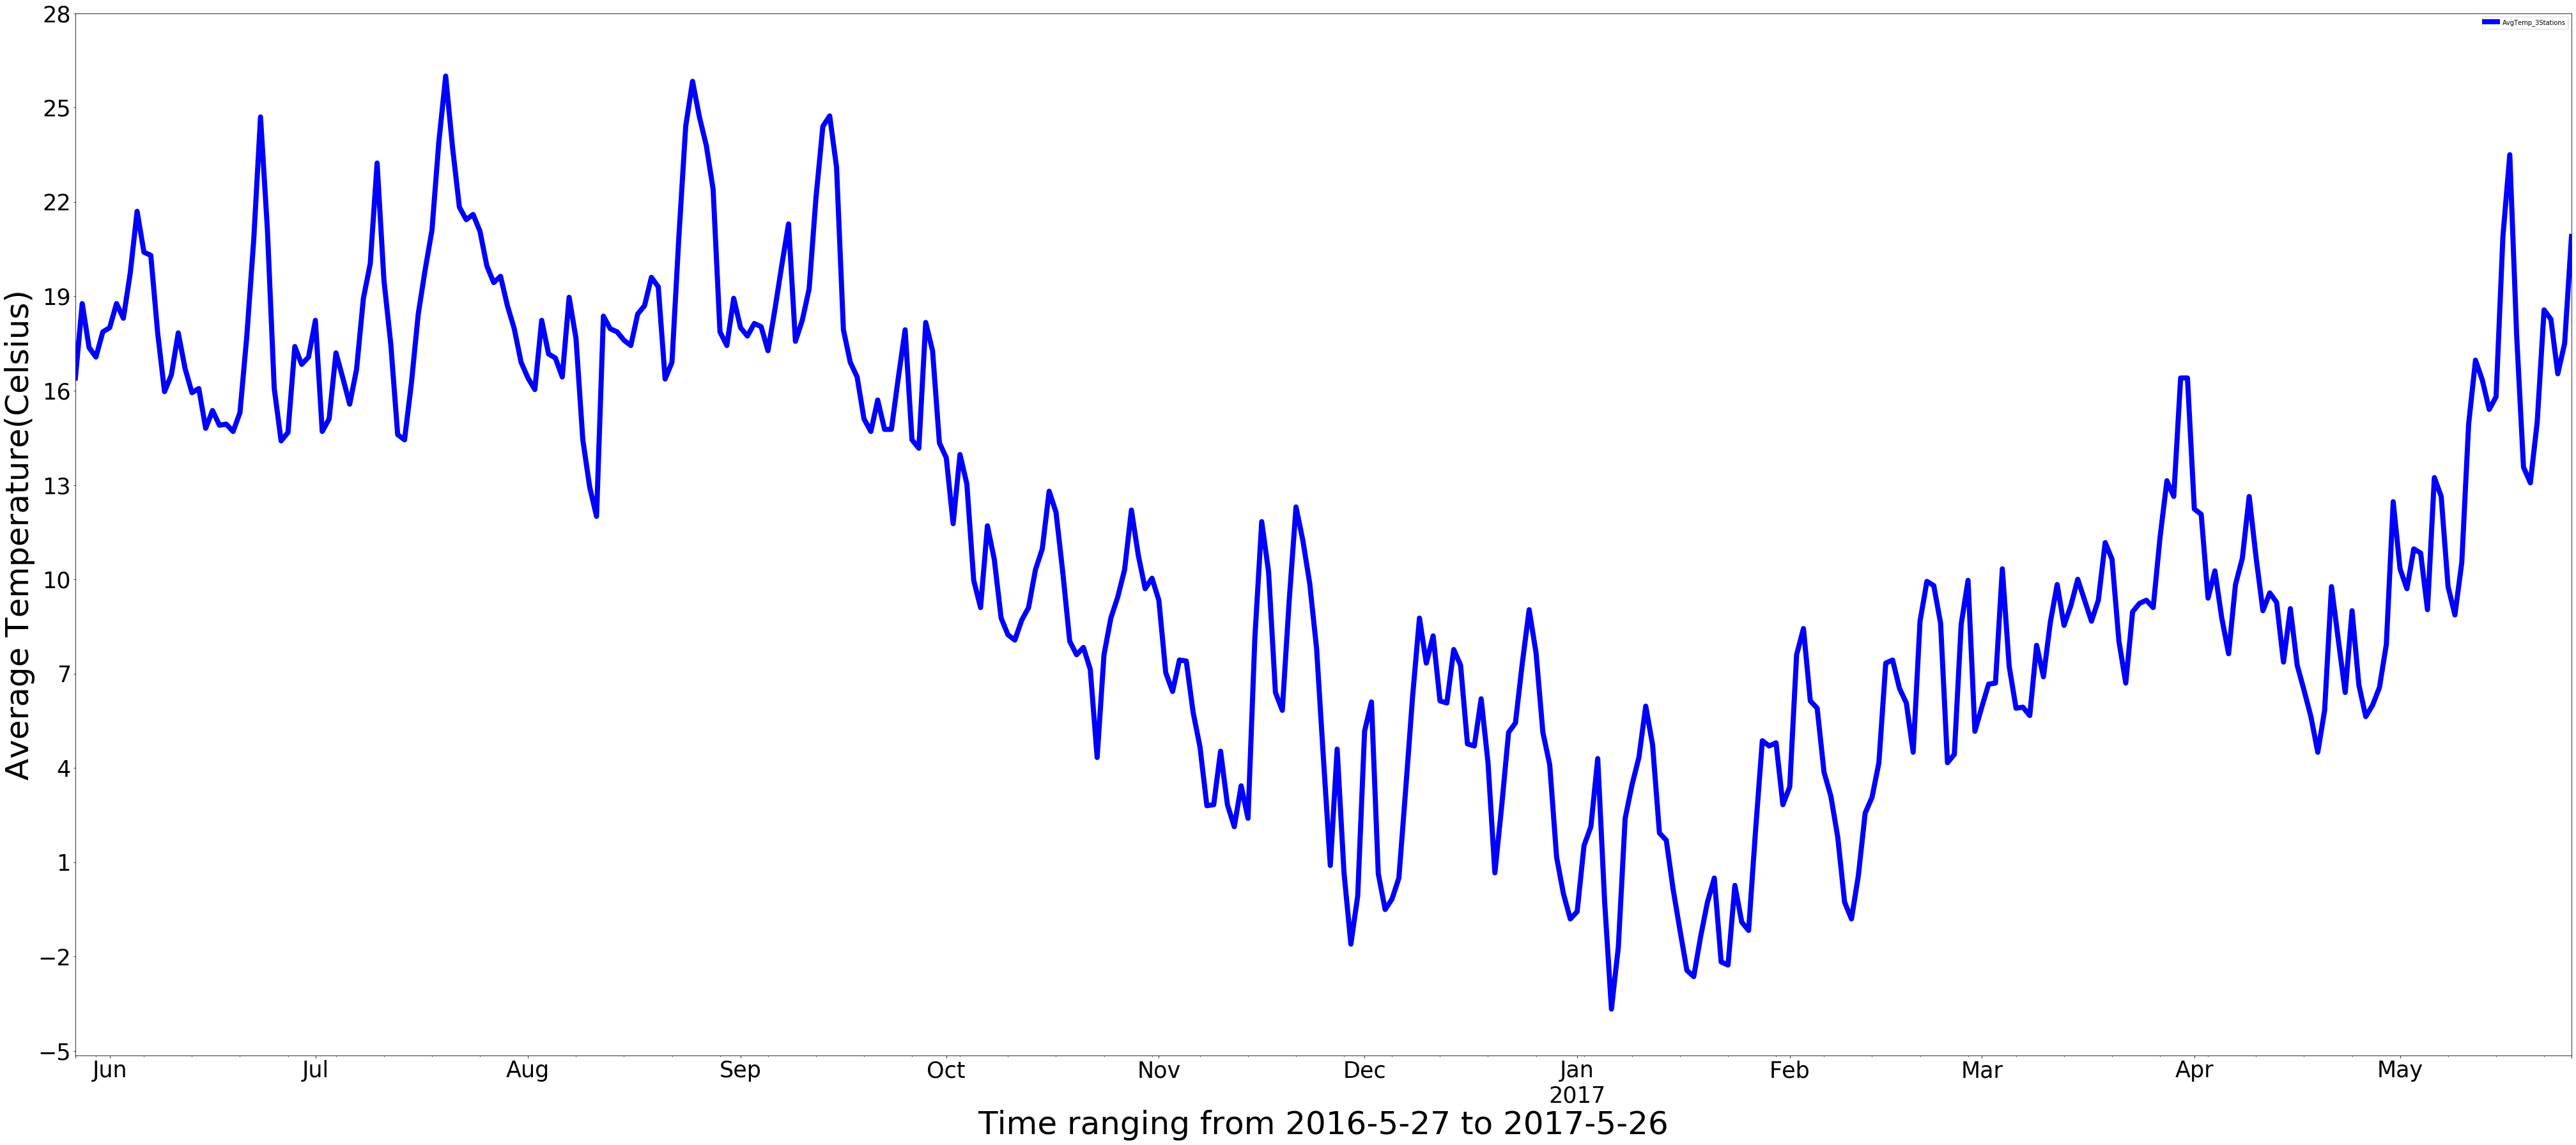

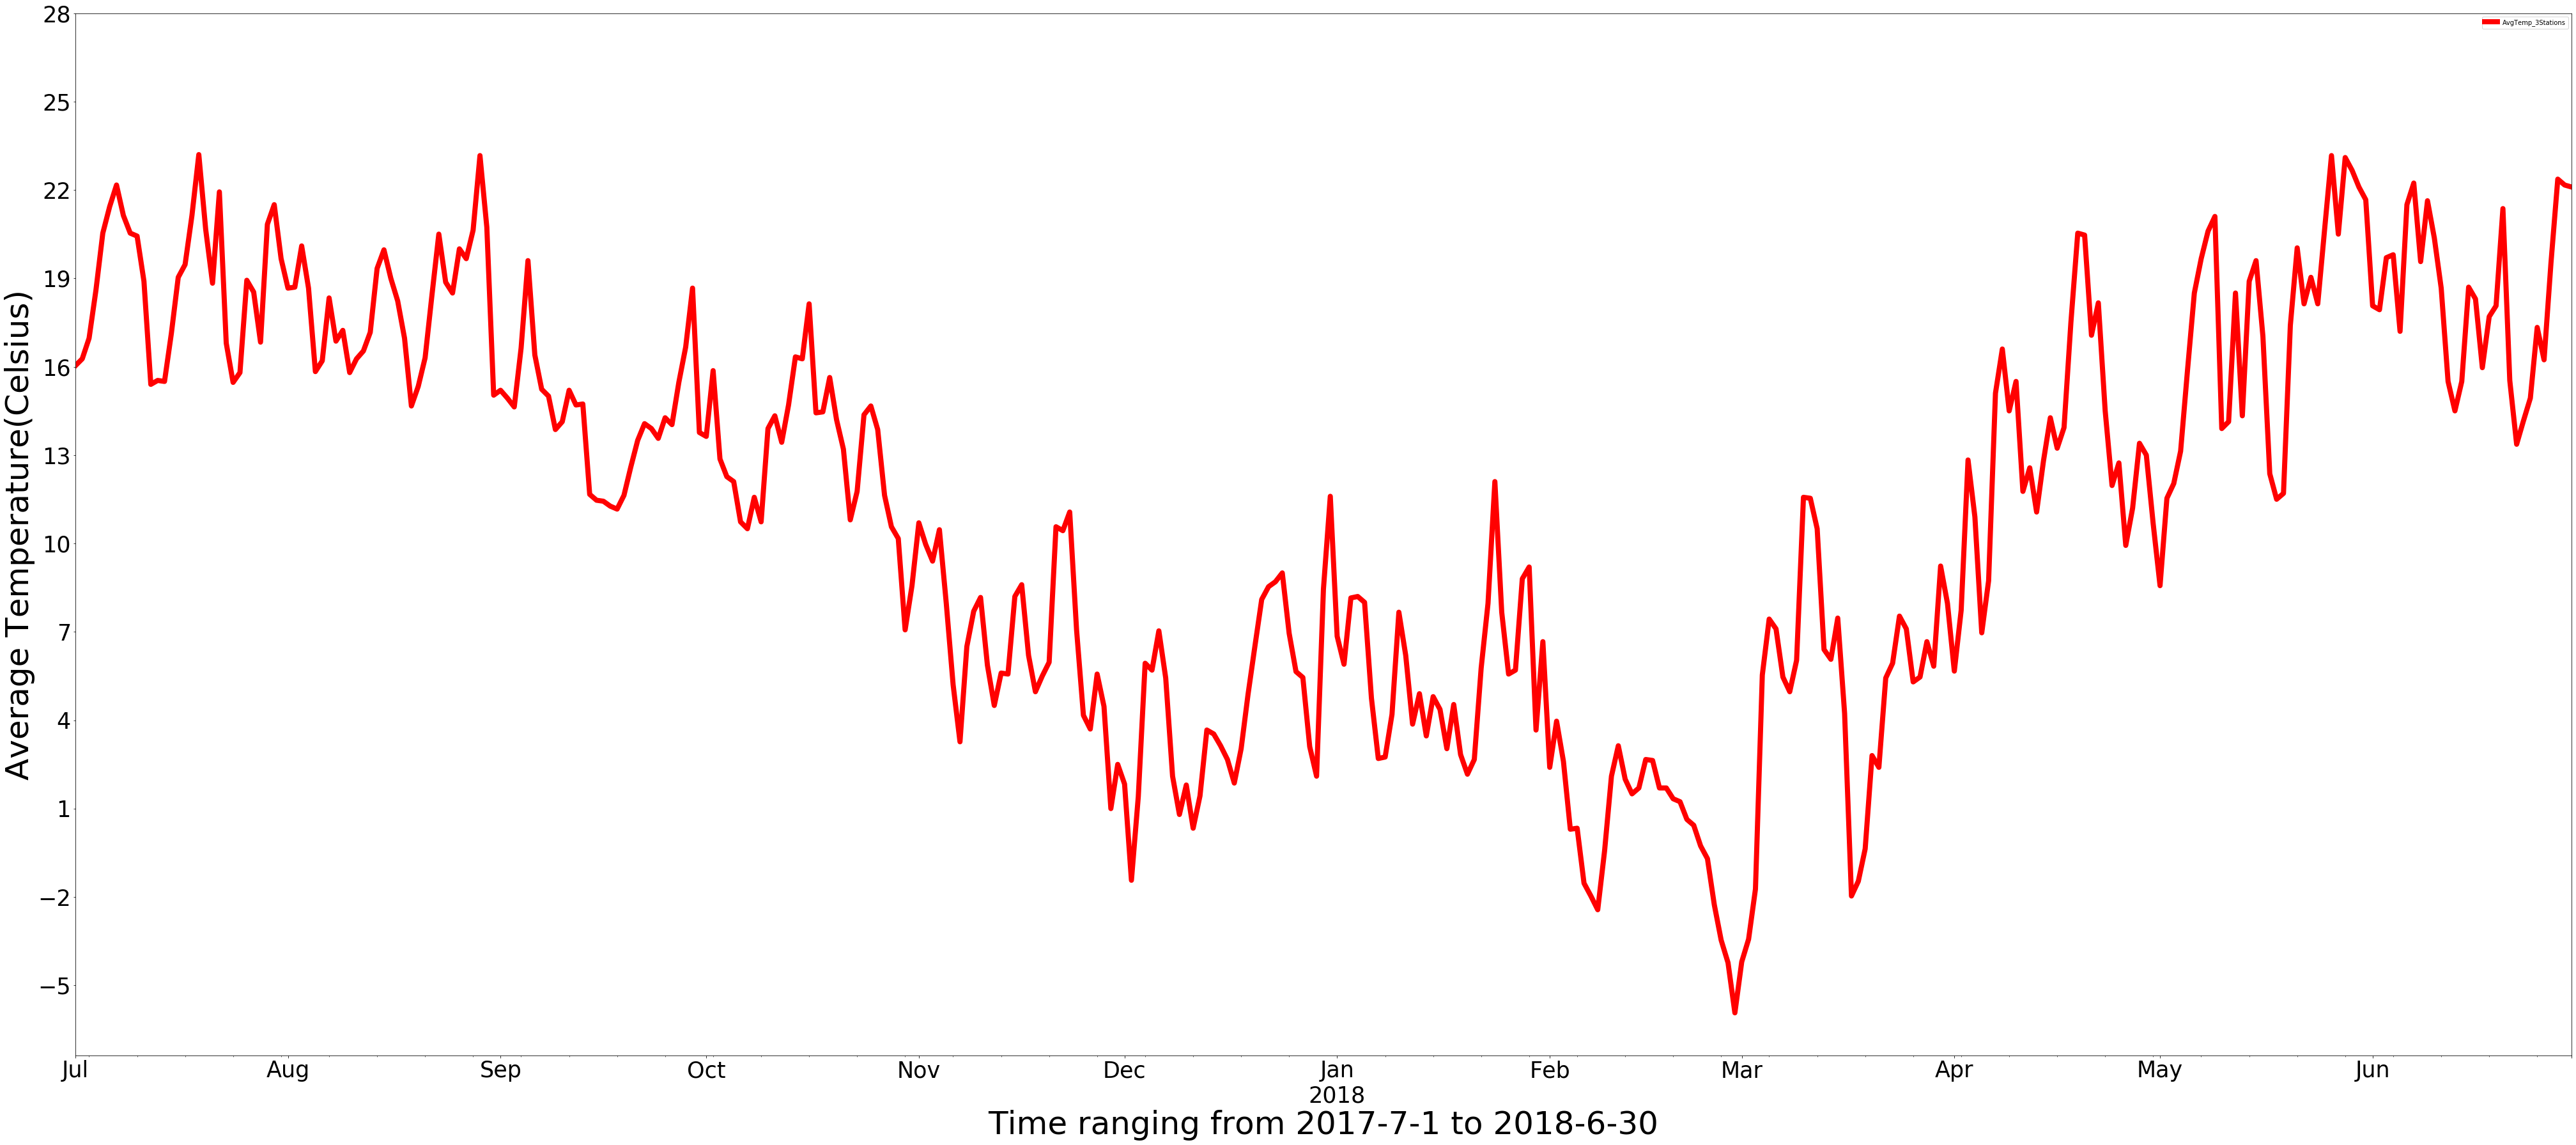

In [264]:
# Line plot for tempertaure vs time ranging from 2015-5-9 to 2016-5-8 for average temperatures in 3 stations considered
isWithinDaterange2016 = (df_selectedDateRange['time'] <= pd.Timestamp(2016, 5, 8)) & (df_selectedDateRange['time'] >= pd.Timestamp(2015, 5, 9))
df_selectedDateRange2016 = df_selectedDateRange[isWithinDaterange2016]
df_selectedDateRange2016.plot(kind='line',x='time',y='AvgTemp_3Stations',color='maroon', linewidth = 8,figsize=(70, 30))

plt.xlabel('Time ranging from 2015-5-9 to 2016-5-8', fontsize=50)
plt.ylabel('Average Temperature(Celsius)', fontsize=50)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.yticks(np.arange(-5, 30, 3))
plt.tick_params(axis='both', which='minor', labelsize=35)

# line plot for tempertaure vs time ranging from 2016-5-27 to 2017-5-26 for average temperatures in 3 stations considered
isWithinDaterange2017 = (df_selectedDateRange['time'] <= pd.Timestamp(2017, 5, 26)) & (df_selectedDateRange['time'] >= pd.Timestamp(2016, 5, 27))
df_selectedDateRange2017 = df_selectedDateRange[isWithinDaterange2017]
df_selectedDateRange2017.plot(kind='line',x='time',y='AvgTemp_3Stations',color='blue',linewidth = 8, figsize=(70, 30))

plt.xlabel('Time ranging from 2016-5-27 to 2017-5-26', fontsize=50)
plt.ylabel('Average Temperature(Celsius)', fontsize=50)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.yticks(np.arange(-5, 30, 3))
plt.tick_params(axis='both', which='minor', labelsize=35)

# line plot for tempertaure vs time ranging from 2017-7-1 to 2018-6-30 for average temperatures in 3 stations considered
isWithinDaterange2018 = (df_selectedDateRange['time'] <= pd.Timestamp(2018, 6, 30)) & (df_selectedDateRange['time'] >= pd.Timestamp(2017, 7, 1))
df_selectedDateRange2018 = df_selectedDateRange[isWithinDaterange2018]
df_selectedDateRange2018.plot(kind='line',x='time',y='AvgTemp_3Stations',color='red',linewidth = 8, figsize=(70, 30))


plt.xlabel('Time ranging from 2017-7-1 to 2018-6-30', fontsize=50)
plt.ylabel('Average Temperature(Celsius)', fontsize=50)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.yticks(np.arange(-5, 30, 3))
plt.tick_params(axis='both', which='minor', labelsize=35)
plt.show()

### Plotting the average temperature for 3 stations of each time period in one graph

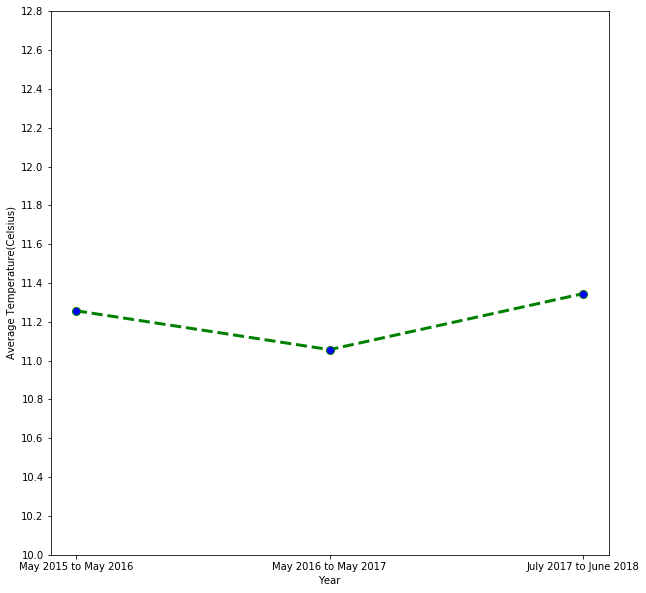

[11.257103825136603, 11.056803652968044, 11.345296803652955]

In [265]:
import numpy as np

date_from = [pd.Timestamp(2015, 5, 9), pd.Timestamp(2016, 5, 27), pd.Timestamp(2017, 7, 1)]
date_to = [pd.Timestamp(2016, 5, 8), pd.Timestamp(2017, 5, 26), pd.Timestamp(2018, 6, 30)]


avg_temperature = []
df_yearly_avgTemp = pd.DataFrame()

#Calculating average temperature for each time period for each year
i = 0
for item in date_from:
    isWithinDaterange = (df_selectedDateRange['time'] <= date_to[i]) & (df_selectedDateRange['time'] >= date_from[i])
    data_frame=df_selectedDateRange[isWithinDaterange]
    # Change column name for reuired station id in the next line
    avg_temperature.append(data_frame['AvgTemp_3Stations'].mean())
    i += 1
    
year = [2016,2017,2018]  
yAxis = ['May 2015 to May 2016', 'May 2016 to May 2017', 'July 2017 to June 2018']
avgTemp = [avg_temperature[0], avg_temperature[1], avg_temperature[2]]
df_yearly_avgTemp['time'] = year
df_yearly_avgTemp['avg_Temperature(o C)'] = avgTemp
export_csv = df_yearly_avgTemp.to_csv (r'Temperature_Yearly_Data.csv', index = None, header=True)

plt.figure(figsize=(10,10))
plt.plot(yAxis, avgTemp, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 

plt.yticks(np.arange(10, 13, 0.2))

plt.xlabel('Year')
plt.ylabel('Average Temperature(Celsius)')
    
plt.show()
avg_temperature

### Finding the correlation between avg temperature and cumulative precptation and NDVI of ROI 1 (Forest area)

   time  cum_precipitation(mm)  avg_Temperature(o C)  NDVI ROI1
0  2016                  829.4             11.257104   0.845702
1  2017                  874.0             11.056804   0.930787
2  2018                  738.6             11.345297   0.899335


,cum_precipitation(mm),avg_Temperature(o C),NDVI ROI1
cum_precipitation(mm),1.000000,-0.915032,0.178731
avg_Temperature(o C),-0.915032,1.000000,-0.560431
NDVI ROI1,0.178731,-0.560431,1.000000


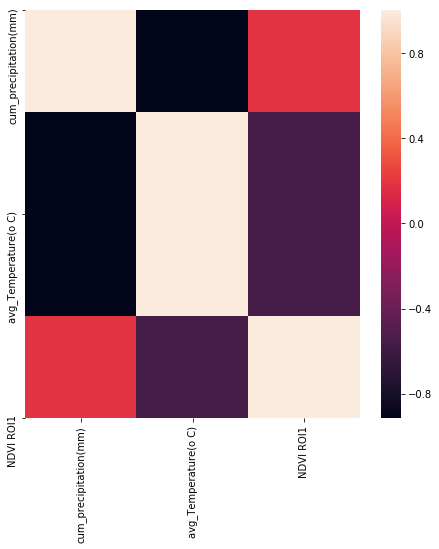

In [266]:
#Reading csv files created in earlier steps
df_precipitation_data = pd.read_csv(r'Precipitation_Yearly_Data.csv')    #Created in ExtractPrecipitatonData.ipynb
df_temperature_data = pd.read_csv(r'Temperature_Yearly_Data.csv')
df_NdviRoi1_data = pd.read_csv(r'NDVIData_ROI1.csv')

#Merge all the dataframes of data read
df_precipit_temp_Ndvi_merge = df_precipitation_data.merge(df_temperature_data,on='time').merge(df_NdviRoi1_data,on='time')
print(df_precipit_temp_Ndvi_merge)
df_precipit_temp_Ndvi_merge = df_precipit_temp_Ndvi_merge.drop(['time'], axis=1)

# pearson coefficient
corr = df_precipit_temp_Ndvi_merge.corr(method ='pearson')

#Plotting heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(7.5,7.5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

corr

### Finding correlation for daily data of temperature and precipitation only

In [267]:
# daily data correlation
df_temperature_data = pd.read_csv(r'Temperature_Full_Data.csv') 
df_precipitation_data = pd.read_csv(r'Precipitaion_Full_Data.csv')


df_precipit_temp_merge = df_precipitation_data.merge(df_temperature_data[['time','AvgTemp_3Stations']],on='time')
df_precipit_temp_merge.corr(method='pearson')

,Xanten,AvgTemp_3Stations
Xanten,1.000000,-0.454054
AvgTemp_3Stations,-0.454054,1.000000
